### Calculate spatially correlated random error on a DoD

- Uses a shapefile polygon to define a stable area
- imports the DoD as a Geotiff raster
- Clips DoD raster using a polygon
- converts clipped raster to x, y, z points
- performs Kriging

*Must be run from conda env "py38"*

conda activate py38

In [15]:
import osgeo
import rasterio

from rasterio.mask import mask
import geopandas as gpd
import numpy as np
import pandas as pd
from pykrige.ok import OrdinaryKriging

import matplotlib.pyplot as plt
# IO - read text
from pyinterpolate import read_txt
# Experimental variogram
from pyinterpolate import build_experimental_variogram
# Theoretical Variogram
from pyinterpolate import TheoreticalVariogram, build_theoretical_variogram

from pyproj import CRS

from pathlib import Path

In [71]:
indod = Path(r"C:\Users\jlogan\OneDrive - DOI\LRDP\LosPadresRes\DoD\DoD_2017-HDR_Reinterp_script_gen_clipped.tif")
inshp = Path(r"C:\Users\jlogan\OneDrive - DOI\LRDP\LosPadresRes\DoD\shp\Stable_areas_script_zonal_stats.shp")

out_clip_ras = Path(r"C:\Users\jlogan\OneDrive - DOI\LRDP\LosPadresRes\DoD\temp_clipped.tif")
out_clip_pts_shp = Path(r"C:\Users\jlogan\OneDrive - DOI\LRDP\LosPadresRes\DoD\temp_clipped_pts.shp")

# stable_poly_id = [1, 2]
stable_poly_id = [2]

In [72]:
# Read the polygon shapefile using geopandas
polygon_gdf = gpd.read_file(inshp)

#filter only stable polygons
polygon_gdf = polygon_gdf.loc[polygon_gdf['id'].isin(stable_poly_id)]

# Read the raster using rasterio
with rasterio.open(indod) as src:
    # Clip the raster using the shapefile geometry
    clipped_raster, clipped_transform = rasterio.mask.mask(src, polygon_gdf.geometry, crop=True)
    clipped_meta = src.meta

# Update the metadata of the clipped raster
clipped_meta.update({
    'height': clipped_raster.shape[1],
    'width': clipped_raster.shape[2],
    'transform': clipped_transform
})

# # Write the clipped raster to the output path
# with rasterio.open(out_clip_ras, 'w', **clipped_meta) as dst:
#     dst.write(clipped_raster)

# Extract the x, y coordinates from the transform
x_coords = []
y_coords = []
z_values = []

for row in range(clipped_raster.shape[1]):
    for col in range(clipped_raster.shape[2]):
        x, y = rasterio.transform.xy(clipped_transform, row, col)
        value = clipped_raster[0, row, col]  # Assume single-band raster

        if value != clipped_meta['nodata']:
            x_coords.append(x)
            y_coords.append(y)
            z_values.append(value)

# Create a pandas DataFrame with x, y, z values
df = pd.DataFrame({'x': x_coords, 'y': y_coords, 'z': z_values})

#output points as shape
geometry = gpd.points_from_xy(df['x'], df['y'])
gdf = gpd.GeoDataFrame(df, geometry=geometry)
gdf.crs = clipped_meta['crs']
gdf.to_file(out_clip_pts_shp, driver='ESRI Shapefile')
    


In [42]:
# # Don't use.... can't handle large datasets
# #Get the semi-variogram values through kriging 
# #(using pykrige.... only works for ~1000 points)

# #sample list
# sampdf = df.sample(n=1000, random_state=1)

# # Define the kriging model without nugget effect
# OK = OrdinaryKriging(sampdf['x'], sampdf['y'], sampdf['z'], variogram_model='spherical')

# # Perform ordinary kriging
# z_pred, sigmasq_pred = OK.execute('grid', sampdf['x'], sampdf['y'])

# # Get the sill value
# sill = OK.variogram_model

# # Get the range
# range_value = OK.variogram_model

# # Print the sill value and range
# print(f'Using {OK.variogram_model} Variogram Model')
# print(f'Partial Sill: {OK.variogram_model_parameters[0]}')
# print(f'Full Sill: {OK.variogram_model_parameters[0] + OK.variogram_model_parameters[2]}')
# print(f'Range: {OK.variogram_model_parameters[1]}')
# print(f'Nugget: {OK.variogram_model_parameters[2]}')

Use this plot to estimate range for subsequent autofit
'Warning! Attribute is_variance is set to False but you try to plot this object! Plot has been cancelled.\n'


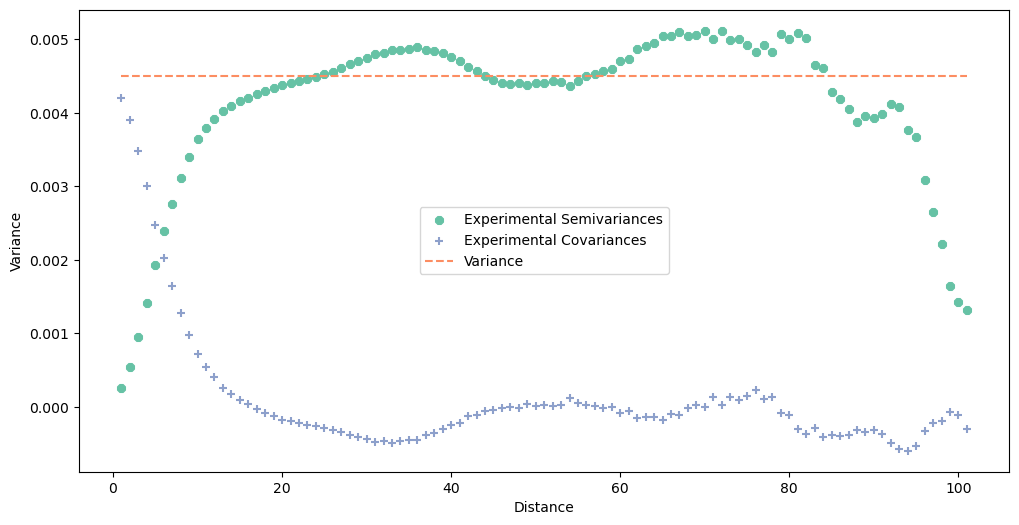

In [74]:
#Get the semi-variogram values through kriging 
#(using pyinterpolate library, with help from docs here: 
# https://pyinterpolate.readthedocs.io/en/latest/usage/tutorials/Semivariogram%20Estimation%20(Basic).html

#sample list
# sampdf = df.sample(n=10000, random_state=1)
data = df[['x','y','z']].to_numpy()

# Create experimental semivariogram
step_radius = 1  # meters
max_range = 102  # meters

experimental_variogram = build_experimental_variogram(input_array=data, step_size=step_radius, max_range=max_range)
print('Use this plot to estimate range for subsequent autofit')
experimental_variogram.plot(plot_semivariance=True, plot_covariance=True, plot_variance=True)

Spherical model RMSE: 0.0010095127570003048


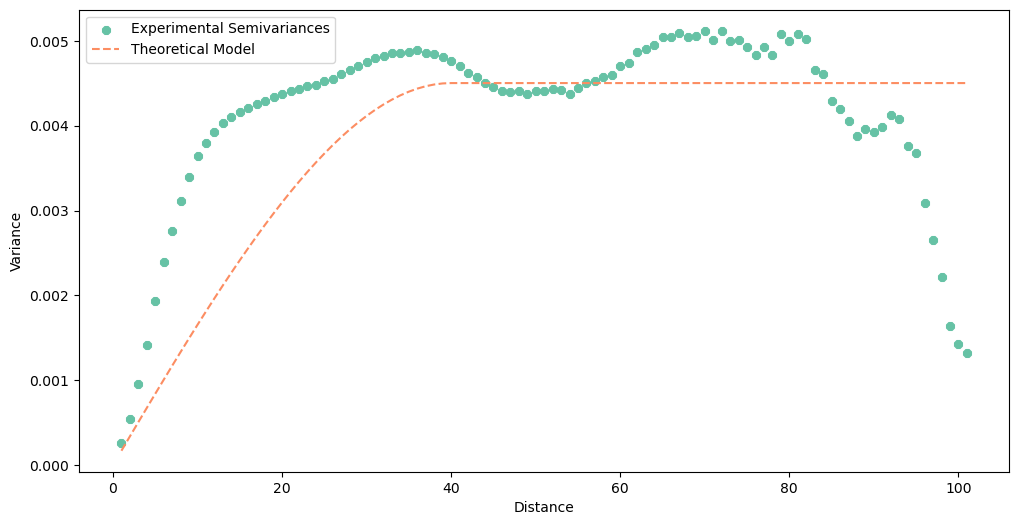

In [75]:
#Use plot above to estimate range
sill = experimental_variogram.variance
nugget = 0
var_range = 40

spherical_model = build_theoretical_variogram(experimental_variogram=experimental_variogram,
                                              model_type='spherical',
                                              sill=sill,
                                              rang=var_range,
                                              nugget=nugget)

print(f'Spherical model RMSE: {spherical_model.rmse}')

spherical_model.plot()

In [76]:
semivariogram_model = TheoreticalVariogram()
fitted = semivariogram_model.autofit(
    experimental_variogram=experimental_variogram,
    model_types='all',
    nugget=0,
    rang=var_range,
    sill=sill)
print(f"Chosen model type: {fitted['model_type']}\nNugget: {fitted['nugget']}\nSill: {fitted['sill']}\nRange: {fitted['range']}\nRMSE: {fitted['rmse']}")

Chosen model type: spherical
Nugget: 0
Sill: 0.0045023222898516796
Range: 40
RMSE: 0.0010095127570003048


Optimized model type: circular
Nugget: 0
Optimized Sill: 0.0045023222898516796
Optimized Range: 15.610349843043949
RMSE: 0.0006994328627538657


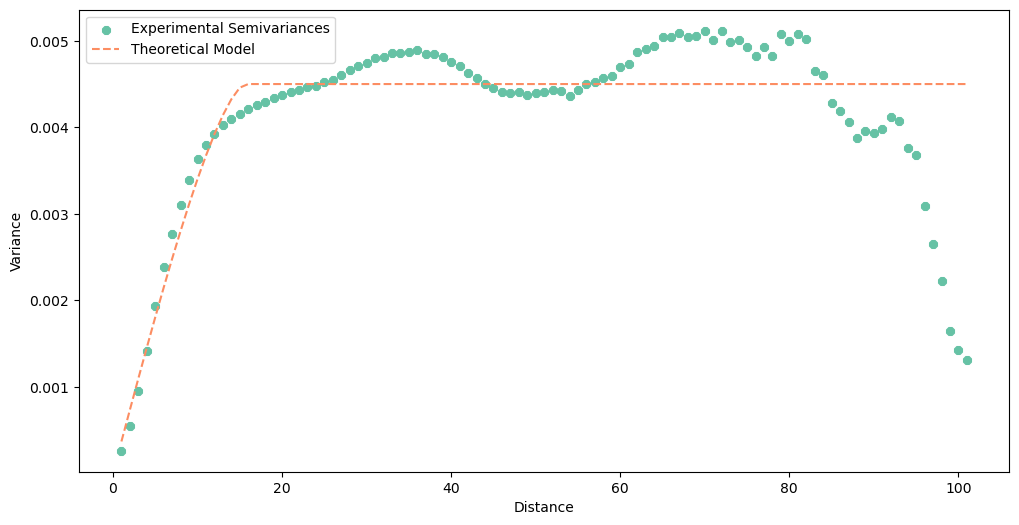

In [77]:
fitted = semivariogram_model.autofit(experimental_variogram=experimental_variogram, nugget=0)
print(f"Optimized model type: {fitted['model_type']}\nNugget: {fitted['nugget']}\nOptimized Sill: {fitted['sill']}\nOptimized Range: {fitted['range']}\nRMSE: {fitted['rmse']}")
semivariogram_model.plot()